In [2]:
!pip install pennylane
!python -m pip install pennylane-sf
!pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 17.3 MB/s eta 0:00:00

In [3]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import strawberryfields as sf
import torch
import tensorflow as tf

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy


env: OMP_NUM_THREADS=1


In [4]:
np.random.seed(0)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset

In [6]:
def create_data_set(drop: float):
    np.random.seed(0)
    l = 150
    n = 2

    X1 = np.array([[-1, -1]]) + drop*np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop*np.random.randn(l, n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    X = np.vstack((X1[10:], X2[10:]))
    ValX = np.vstack((X1[:10], X2[:10]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(l-10), [1]*(l-10)])
    ValY = np.hstack([[0]*10, [1]*10])

    visualize_dataset(X, y, ValX, ValY)

    return torch.tensor(X, requires_grad=False), torch.tensor(y, requires_grad=False), torch.tensor(ValX, requires_grad=False), torch.tensor(ValY, requires_grad=False)

In [7]:
def visualize_dataset(trainX, trainY, ValX, ValY)-> None:
    colors = ['blue', 'red', 'yellow', 'green']

    for k in np.unique(trainY):
        plt.plot(trainX[trainY==k, 0], trainX[trainY==k, 1], 'o', label='class {}'.format(k), color = colors[k])

    for k in np.unique(ValY):
        plt.plot(ValX[ValY==k, 0], ValX[ValY==k, 1], 'o', label='class {}'.format(k), color = colors[k+2])

    plt.legend(loc='best')
    plt.show()
    plt.close()

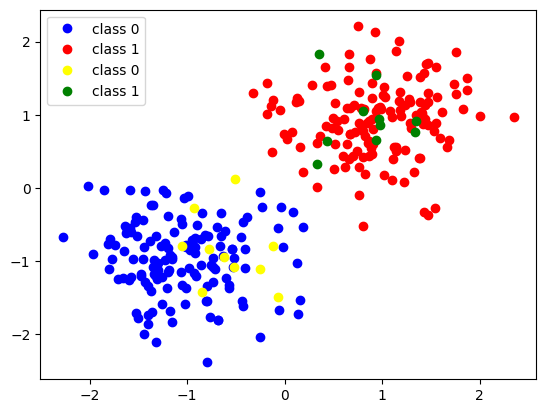

In [8]:
trainX, trainY, ValX, ValY = create_data_set(0.5)

# Model

In [9]:
shots = 100  # кол-во измерений для набора статистики
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=5, shots=shots)

In [10]:
params_num = 8

def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)
    
    qml.Beamsplitter(params[0], params[1], wires=[0, 1])
    # qml.Rotation(params[2], wires=0)
    # qml.Rotation(params[3], wires=1)
    qml.Displacement(params[2], 0.0, wires=1)
    qml.Displacement(params[3], 0.0, wires=1)
    qml.QuadraticPhase(params[4], wires=0)
    qml.QuadraticPhase(params[5], wires=0)
    qml.Kerr(params[6], wires=0)
    qml.Kerr(params[7], wires=1)


@qml.qnode(dev, interface='torch')
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='torch')
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([0,2], requires_grad=False), wires=[0,1]))


def classifier(params, x):
    o0 = circuit_0(params,x)
    o1 = circuit_1(params,x)
    p0 = o0/(o0+o1)
    return p0  # , 1-p0

In [11]:
def square_loss(labels, predictions):
    loss = torch.sum((labels - torch.absolute(predictions)) ** 2) / labels.size(dim=0)
    # print(loss)
    return loss

def log_loss(labels, predictions):
    loss = torch.sum(labels * torch.log(predictions) + (1 - labels)*torch.log(1 - predictions))

    return loss

# def accuracy(labels, predictions):
#     acc = np.sum(np.where(np.abs(labels - predictions) < 1e-5, 1, 0))
#     return acc

# def square_loss(labels, predictions):
#     loss = 0
#     print(f'predictions: {predictions}')
#     for l, p in zip(labels, np.absolute(predictions)):
#         loss = loss + (l - p) ** 2
#     loss = loss / len(labels)
#     print(loss)
#     return loss

def accuracy(labels, predictions):
    acc = 0
    pred = torch.round(predictions)
    for l, p in zip(labels, torch.absolute(pred)):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / labels.size(dim=0)
    return acc

In [29]:
def cost(var, data_input, labels):
    predictions = torch.tensor([classifier(var, x) for x in data_input], requires_grad=True)
    loss = torch.absolute(square_loss(labels, predictions))
    # loss = torch.absolute(log_loss(labels, predictions)) 
    
    return loss

In [30]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

var = torch.tensor([0.5]*params_num).requires_grad_(True)
steps = 40

opt = torch.optim.SGD([var], lr = 0.35)

def closure():
    opt.zero_grad()
    loss = cost(var, trainX, trainY)
    # print(loss)
    loss.backward()
    # print(params.grad)
    return loss

for step in range(steps):
    opt.step(closure)

    print(f'trainable params: {var}')

    predictions = torch.tensor([classifier(var, x) for x in ValX], requires_grad=False)
    val_accuracy = accuracy(ValY, np.round(predictions))
    val_loss = square_loss(ValY, predictions)

    predictions = torch.tensor([classifier(var, x) for x in trainX], requires_grad=False)
    train_accuracy = accuracy(trainY, np.round(predictions))
    train_loss = square_loss(trainY, predictions)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

trainable params: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       requires_grad=True)
Iter:     1 | Train Loss: 4.8821352 | Train accuracy: 0.5321428571428571 | Val Loss: 0.2972104 | Val_accuracy: 0.7 
trainable params: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       requires_grad=True)
Iter:     2 | Train Loss: 0.3354135 | Train accuracy: 0.525 | Val Loss: 0.3687767 | Val_accuracy: 0.55 
trainable params: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       requires_grad=True)
Iter:     3 | Train Loss: 0.3603399 | Train accuracy: 0.4928571428571429 | Val Loss: 0.3803246 | Val_accuracy: 0.55 
trainable params: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       requires_grad=True)
Iter:     4 | Train Loss: 0.5826596 | Train accuracy: 0.5 | Val Loss: 0.9516250 | Val_accuracy: 0.5 
trainable params: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],

KeyboardInterrupt: ignored

In [24]:
trainX.size(dim=0)

280

In [25]:
var = torch.tensor([0.5]*params_num, requires_grad=True)
weight_shapes = {"var": params_num}

qlayer = qml.qnn.TorchLayer(classifier, weight_shapes)
model = torch.nn.Sequential(qlayer)

opt = torch.optim.SGD(model.parameters(), lr=0.5)
loss = torch.nn.MSELoss()

epochs = 8
batch_size = 5
batches = trainX.size(dim=0) // batch_size

data_loader = torch.utils.data.DataLoader(list(zip(trainX, trainY)), batch_size=batch_size,
                                          shuffle=True, drop_last=True)

for epoch in range(epochs):

    running_loss = 0

    for x, y in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(x), y)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

AttributeError: ignored

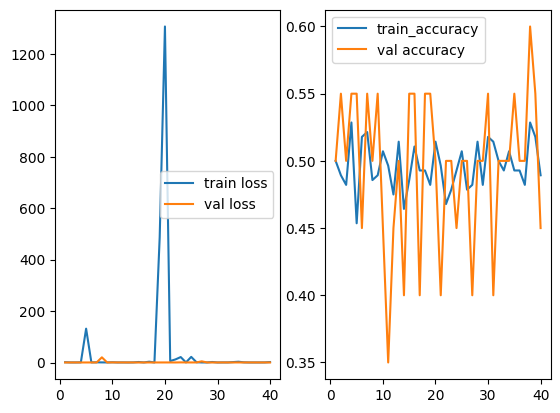

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(range(1, steps+1), train_loss_history, label='train loss')
axs[0].plot(range(1, steps+1), val_loss_history, label='val loss')
# axs[0].
axs[0].legend()

axs[1].plot(range(1, steps+1), train_acc_history, label='train_accuracy')
axs[1].plot(range(1, steps+1), val_acc_history, label='val accuracy')
axs[1].legend()

plt.show()

#with Tensorflow

In [14]:
def create_data_set(drop: float):
    np.random.seed(0)
    l = 150
    n = 2

    X1 = np.array([[-1, -1]]) + drop*np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop*np.random.randn(l, n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    X = np.vstack((X1[10:], X2[10:]))
    ValX = np.vstack((X1[:10], X2[:10]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(l-10), [1]*(l-10)])
    ValY = np.hstack([[0]*10, [1]*10])

    visualize_dataset(X, y, ValX, ValY)

    return tf.constant(X), tf.constant(y), tf.constant(ValX), tf.constant(ValY)

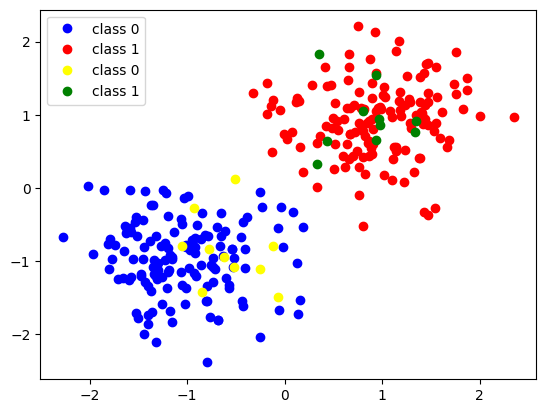

In [15]:
trainX, trainY, ValX, ValY = create_data_set(0.5)

In [16]:
shots = 100  # кол-во измерений для набора статистики
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=5, shots=shots)

In [17]:
params_num = 8

def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)
    
    qml.Beamsplitter(params[0], params[1], wires=[0, 1])
    # qml.Rotation(params[2], wires=0)
    # qml.Rotation(params[3], wires=1)
    qml.Displacement(params[2], 0.0, wires=0)
    qml.Displacement(params[3], 0.0, wires=1)
    qml.QuadraticPhase(params[4], wires=0)
    qml.QuadraticPhase(params[5], wires=0)
    qml.Kerr(params[6], wires=0)
    qml.Kerr(params[7], wires=1)


@qml.qnode(dev, interface='tf')
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='tf')
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([0,2], requires_grad=False), wires=[0,1]))


def classifier(params, x):
    o0 = circuit_0(params,x)
    o1 = circuit_1(params,x)
    p0 = o0/(o0+o1)
    return p0  # , 1-p0